<a href="https://colab.research.google.com/github/Manuel-FA/Deep_Learning/blob/main/Car%20Object%20Detection%20-%20Dataset_1%20-%20Beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#000080B">**ABSTRACT**</font>

*   RESUMEN
*   Model:
*   Libraries used: Numpy, Pandas, MatPlotLib, Seaborn, Scikitplot and Sklearn

# <font color="#000080B">**1. Introduction**</font>
---


## <font color="#000080B">**1.1. Content**</font>


    1. Introduction
      1.1. Content
      1.2. Problem statement
    2. Project preparation
      2.1. Libraries import
      2.2. Data import
    3. Exploratory data analysis
      3.1. Data information
      3.2. Categorical variables
      3.3. Univariate analysis
      3.4. Bivariate analysis
    4. Data prepprocessing
      4.1. Removing redundat variables
      4.2. Removing outliers
      4.3. Filling missing values
      4.4. Encoding categorical features
    5. Modeling
      5.1. Dataset preparation
      5.2. Training and validation
    6. Interpretation of results
      6.1. Model evaluation
      6.2. ROC curve
      6.3. Important features


## <font color="#000080B">**1.2. Problem statement**</font>

CONTEXTO DEL PROBLEMA A RESOLVER

## <font color="#000080B">**2.1. Libraries import**</font>

In [1]:
# data import
from google.colab import drive

# data manipulation
import numpy as np
import pandas as pd

# visualization/image processing
import matplotlib.pyplot as plt
import cv2

# machine learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
#es un módulo en la biblioteca estándar de Python que proporciona una forma más intuitiva y robusta de trabajar con rutas de
#archivos y directorios en comparación con métodos más antiguos como os.path
#La clase Path representa rutas de archivos y directorios como objetos que se pueden manipular
#fácilmente y utilizar para diversas operaciones de archivo.
from pathlib import Path

## <font color="#000080B">**2.2. Data import**</font>

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = Path("/content/drive/MyDrive/Datasets/training_images")
test_path = Path("/content/drive/MyDrive/Datasets/testing_images")
train_bounding_boxes = pd.read_csv("/content/drive/MyDrive/Datasets/train_solution_bounding_boxes.csv")

# <font color="#000080B">**3. Exploratory data analysis**</font>
---


In [4]:
train_bounding_boxes.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [5]:
train_bounding_boxes[['xmin', 'ymin', 'xmax', 'ymax']] = train_bounding_boxes[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train_bounding_boxes.drop_duplicates(subset='image', inplace=True, ignore_index=True)

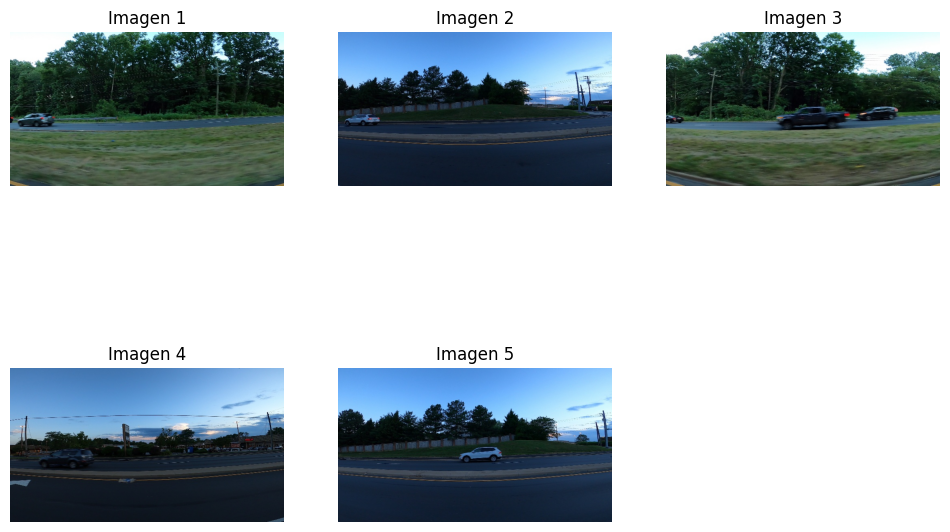

In [6]:
# Supongamos que tienes una lista de rutas de archivo de imágenes en 'image_paths'
#image_paths = ['vid_4_1000.jpg', 'vid_4_10000.jpg', 'vid_4_10040.jpg', 'vid_4_10020.jpg', 'vid_4_10060.jpg']
image_paths = train_bounding_boxes['image'].sample(n=5)

# Crea una figura de Matplotlib para mostrar las imágenes en una ventana
fig = plt.figure(figsize=(12, 8))

for i, name in enumerate(image_paths):
    # Lee la imagen utilizando cv2
    image = cv2.imread(str(train_path/name))

    # Define subtramas para mostrar las imágenes en una cuadrícula
    plt.subplot(2, 3, i + 1)  # Cambia los números para ajustar la cuadrícula

    # Muestra la imagen en la subtrama actual
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Imagen {i+1}')
    plt.axis('off')  # Desactiva los ejes

# Actualiza la ventana de visualización
plt.show()

**A quick formatting note**: the green rectangle represents the correct bounding whereas the red rectangle represents the predicted bounding box.

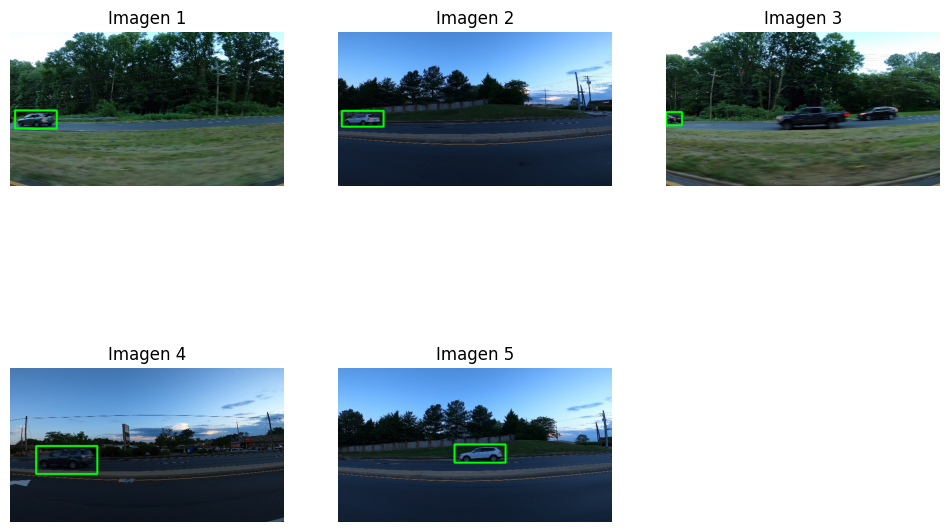

In [7]:
# Crea una figura de Matplotlib para mostrar las imágenes en una ventana
fig = plt.figure(figsize=(12, 8))

for i, name in enumerate(image_paths):
    # Lee la imagen utilizando cv2
    image = cv2.imread(str(train_path/name))

    valor = image_paths.index[i]
    fila_objetivo = train_bounding_boxes.iloc[valor]
    xmin = fila_objetivo['xmin']
    ymin = fila_objetivo['ymin']
    xmax = fila_objetivo['xmax']
    ymax = fila_objetivo['ymax']
    img = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)


    # Define subtramas para mostrar las imágenes en una cuadrícula
    plt.subplot(2, 3, i + 1)  # Cambia los números para ajustar la cuadrícula

    # Muestra la imagen en la subtrama actual
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Imagen {i+1}')
    plt.axis('off')  # Desactiva los ejes

# Actualiza la ventana de visualización
plt.show()

# <font color="#000080B">**4. Modeling**</font>

---

## <font color="#000080B">**4.1. Preparación de datos**</font>

## Data Generator

Before training the model, we must define a generator that keras accepts. If you're not familiar with python generators or are in need of a quick refresher, check out [this resource](https://www.programiz.com/python-programming/generator).

In keras, all we need to do is initialize some arrays containing images and their corresponding bounding box coordinates. Then, we simply return the newly-created arrays in a dictionary.

In [8]:
# esta función serive para organizar la información de la imagen desde la carpeta de imagenes con la información del dataframe de las
# cajas delimitadoras
def data_generator(df=train_bounding_boxes, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size):
                rand_index = np.random.randint(0, train_bounding_boxes.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {'image': images}, {'coords': bounding_box_coords}


## <font color="#000080B">**4.2. Model Building**</font>

In [ ]:
# Aquí, se define la entrada del modelo. El modelo espera imágenes de forma (380, 676, 3),
# que corresponde a imágenes en color con un tamaño de 380 píxeles de alto, 676 píxeles de ancho
#y 3 canales de color (rojo, verde y azul).
input_ = Input(shape=[380, 676, 3], name='image')

# Se inicia una variable x que se utilizará para construir la arquitectura de la red neuronal.
# esta información se gaurdará en la variable "output"
x = input_

# se realiza un conjunto de capas de convolución, normalización y agrupación. En cada iteración se duplica el numero de
# filtros para aumentar gradualmetne la capacidad de la red neuronal
for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

# Después de las capas convolucionales, se aplana la salida utilizando Flatten. Luego, se agregan
# dos capas completamente conectadas (Dense) con activaciones ReLU. La última capa tiene 4 neuronas,
# lo que sugiere que se espera que el modelo produzca 4 valores como salida (posiblemente coordenadas de cajas delimitadoras).
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

#Se realizó una extensa investigación, que en la face de

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 16)      64    

For each output, we need to specify a loss and a metric. To do this, we simply reference the dictionary key used in the generator and assign it our desired loss function/metric.

In [ ]:
# se ajusta las caracteristicas d ela compilación, la métrica qeu se utiliza para valuar es el de error cuadrático medio
model.compile(
    loss={
        'coords': 'mse'
    },
# se utiliza el optimziador Adam, uno muy utilizado
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

Before we actually train the model, let's define a callback that tests the current model on three, randomly selected images.

In [ ]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        # cv2.rectangle se utiliza para dibujar rectángulos en imágenes. Sus argumentos son: Imagen de destino (img), Coordenadas del vértice superior izquierdo (pt1),
        # Coordenadas del vértice inferior derecho (pt2), Color del rectángulo (color) y Grosor del borde (thickness).
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)

    X = example['image']
    y = label['coords']

    pred_bbox = model.predict(X)[0]

    img = X[0]
    gt_coords = y[0]

    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

We'll quickly use these methods to evaluate the current performance of our model.

1/1 [==============================] - 0s 22ms/step


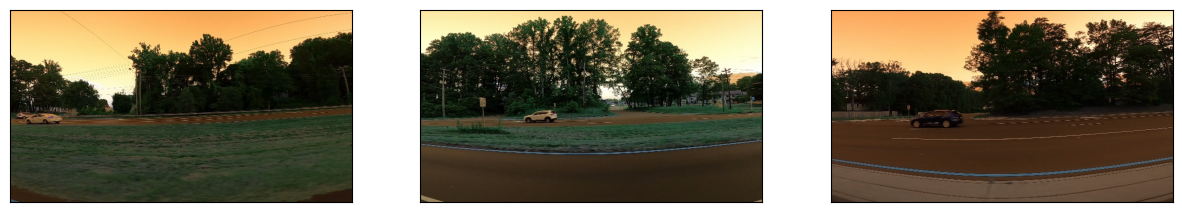

In [ ]:
test(model)

## <font color="#000080B">**5.3. Training and validation**</font>

The model isn't great; in fact, its predictions aren't even visible.

But, the model's poor performance is expected as we haven't even trained the model yet.
So, let's do just that.

We'll use Kaggle's GPU to train the model in order to drastically speed up the training process.

Epoch 1/9
1/1 [==============================] - 0s 39ms/step


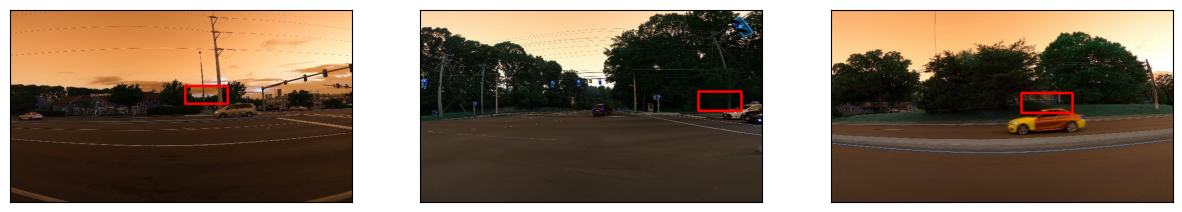

500/500 [==============================] - 375s 719ms/step - loss: 4337.4873 - accuracy: 0.9072
Epoch 2/9
1/1 [==============================] - 0s 54ms/step


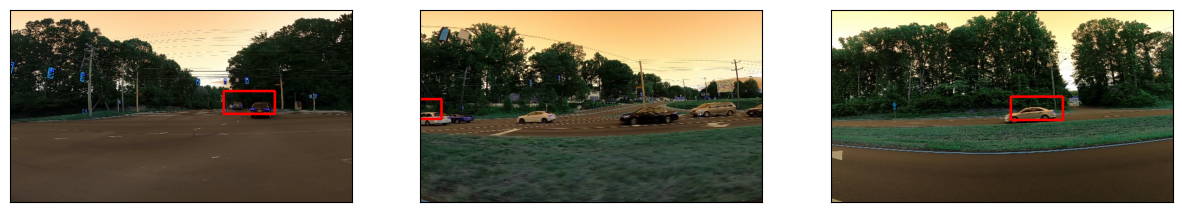

500/500 [==============================] - 161s 323ms/step - loss: 665.1733 - accuracy: 0.9732
Epoch 3/9
1/1 [==============================] - 0s 32ms/step


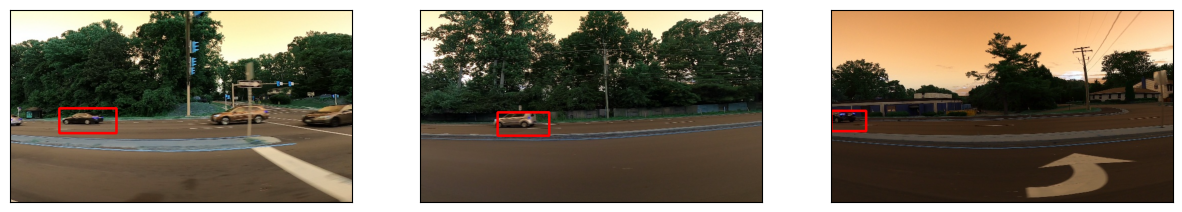

500/500 [==============================] - 164s 328ms/step - loss: 324.3477 - accuracy: 0.9820
Epoch 4/9
473/500 [===========================>..] - ETA: 8s - loss: 192.6514 - accuracy: 0.9861

KeyboardInterrupt: ignored

In [ ]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

The model is doing quite well; the `MSE` is relatively low and the accuracy is very high.

Since the model training seems to be complete, we can now export the model and store it for later use.

# Conclusion
This notebook described the setup of a single object detection model, along with the training process. Moreover, this notebook provided some insight on how to deal with datasets that aren't necessarily in a format compatible with the default keras settings. Lastly, this notebook described the thinking that goes behind approaching a computer vision problem such as single object detection.

For those eager to dive deeper, here are some more computer vision projects:
 - Image Segmentation
 - Single Object Detection (with videos)
 - Multiple Object Detection (with images)
 - Multiple Object Detection (with videos)
 - Object Detection and Classification (with images and videos)

If you found this notebook helpful, consider upvoting. Upvotes allow this notebook to circulate around Kaggle, thus resulting in the notebook reaching and helping more people.

### Thanks for Reading!